## People Tracking Algorithm

Our People Tracking Algorithm is handled using the `TrackedPerson` class. Each instance of this class is responsible for tracking a single person.  

The class provides a unique id for each person and two methods to keep track of the person in different frames of the video. The `update` method is called with the bounding boxes of peoples in a frame. These bounding boxed are usually the result of running a People Detection Algorithm.  

The class provides another method called `predict` to handle predicting the position of the person in the scene.  

Let's see how this class is used:

In [1]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact
import dlib


from packages.utils.videos import VideoSource
from packages.object_detection import ObjectDetector
from packages.utils.visualization import annotation_utils, display_image

In [2]:
vs = VideoSource('./videos/example_01.mp4')

In [3]:
detector = ObjectDetector('ssd_inception_v2')

[INFO] loading model...
Done.


running display


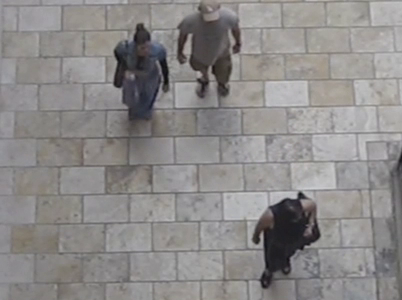

In [4]:
frame1 = vs.get_frame(395)
display_image(frame1)

In [5]:
detections = detector.detect_people(frame1)

running display


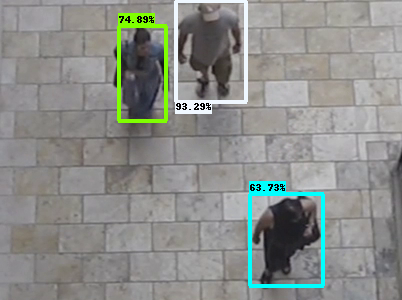

In [6]:
frame1_copy = frame1.copy()
annotation_utils.add_people_detection_result_to_image(frame1_copy, detections)
display_image(frame1_copy)

### The `TrackedPerson` Class

Let's start with a very basic implementation of the class. Handling (for now) only the constructor and the predict methods. We also provide some basic methods for getting the info required to make visualization easier.

In [7]:
class TrackedPerson_v1:
    next_person_id = 0

    def __init__(self, frame, box, score=-1.0):
        self.tracker = dlib.correlation_tracker()
        rect = dlib.rectangle(*box)
        self.tracker.start_track(frame, rect)
        self.detection_score = score
        self.confidence = 11.0
        self.id = TrackedPerson_v1.next_person_id
        TrackedPerson_v1.next_person_id += 1

    def get_box(self):
        pos = self.tracker.get_position()
        start_x = int(pos.left())
        start_y = int(pos.top())
        end_x = int(pos.right())
        end_y = int(pos.bottom())

        return np.array([start_x, start_y, end_x, end_y])

    def predict(self, frame):
        self.confidence = self.tracker.update(frame)
        return self.get_box()

    def get_labels(self):
        confidence = "conf: {:.2f}".format(self.confidence)
        id_label = "ID: {}".format(self.id)
        detection_score = "score: {:.2f}%".format(100*self.detection_score)
        return [id_label, confidence, detection_score]

The class implementation should be very self-explanatory. When an instance of the class is created, a new id is assigned to the new person being tracked. Here we use the dlib's correlation tracker for doing the tracking job.  
We keep some other information as well. We keep the detection score received from the detector (`self.detection_score`).  
We also set the confidence to 11.0. a confidence score more than 10.0 means we are pretty confident about the position of the tracked person. This value will be updated on every frame.

The `predict` method just updates the tracker with new frame and updates the confidence value based on the returned value.

Let's see how this basic model works for us:

### Building a new TrackedPerson

We use the result of our initial detection to track each person:

In [8]:
selected_index = 2
tracked_person = TrackedPerson_v1(frame1, 
                               detections["boxes"][selected_index], 
                               score=detections["scores"][selected_index])

### Using the trackers to track the person

In subsequent frame, we use our trackers to update the bounding box for each TrackedPerson:

running display


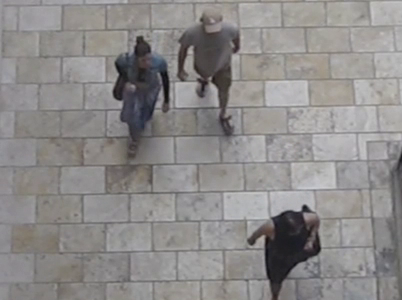

In [9]:
frame2 = vs.get_frame(398)
display_image(frame2)

In [10]:
predicted_box = tracked_person.predict(frame2)
predicted_box

array([250, 205, 323, 295])

running display


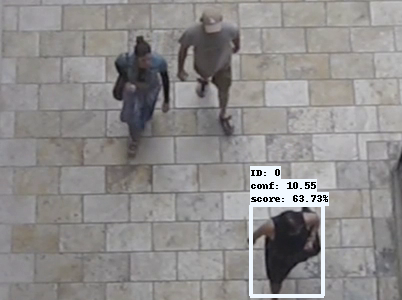

In [11]:
frame2_copy = frame2.copy()
annotation_utils.add_tracked_person_box_to_image(frame2_copy, tracked_person)
display_image(frame2_copy)

### Tracking Performance Over Time

Let's see how the tracking performance changes over time:

In [12]:
detection_frame = 395
frames_after = 200
vs.set_frame_pointer(detection_frame)

frame = vs.get_frame()
detections = detector.detect_people(frame)

tracked_people = []

for (box, score) in zip(detections["boxes"], detections["scores"]):
    tracked_person = TrackedPerson_v1(frame, box, score=score)
    tracked_people.append(tracked_person)

In [13]:
tracking_performance = []

for i in range(frames_after):
    frame = vs.get_frame()
    frame_performance = {}
    for tracked_person in tracked_people:
        tracked_person.predict(frame)
        tracking_state = {
            "box": tracked_person.get_box(),
            "confidence": tracked_person.confidence,
            "id": tracked_person.id,
            "labels": tracked_person.get_labels()
        }
        frame_performance[tracked_person.id] = (tracking_state)
    tracking_performance.append(frame_performance)

Let's have a look at our frames:

<IPython.core.display.Javascript object>


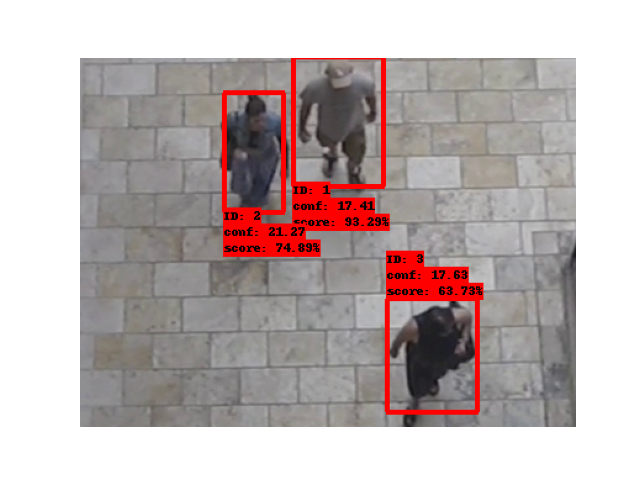

interactive(children=(IntSlider(value=10, description='x', max=199), Output()), _dom_classes=('widget-interact…

<function __main__.update_image(x=10)>

In [14]:
%matplotlib notebook

frame_fig, frame_ax = plt.subplots()

def update_image(x = 10):
    frame_number = detection_frame + 1 + x
    frame = vs.get_frame(frame_number)
    frame_performance = tracking_performance[x]
    for tracked_person_performance in frame_performance.values():
        annotation_utils.add_box_to_image(frame, tracked_person_performance['box'], texts=tracked_person_performance['labels'])
    frame_ax.cla()
    frame_ax.axis('off')
    frame_ax.imshow(frame)
    
interact(update_image, x=(0, frames_after - 1, 1))

And let's have a look at how the confidence changes over time for each tracked person:

In [15]:
confidence_time_series = {}
for frame_after in range(frames_after):
    frame_performance = tracking_performance[frame_after]
    for value in frame_performance.values():
        person_id = value["id"]
        confidence = value["confidence"]
        if person_id in confidence_time_series:
            confidence_time_series[person_id][frame_after] = confidence
        else:
            confidence_time_series[person_id] = np.empty((frames_after,), dtype=float)
            confidence_time_series[person_id][:] = np.NaN

<IPython.core.display.Javascript object>


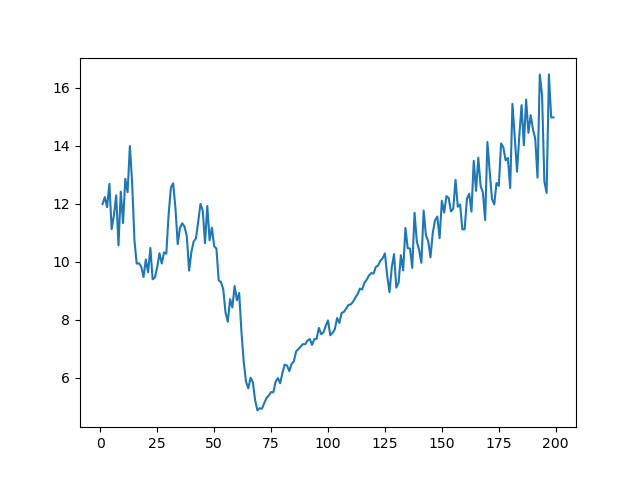

interactive(children=(Dropdown(description='ID', options=(1, 2, 3), value=1), Output()), _dom_classes=('widget…

<function __main__.update_plot(ID)>

In [17]:
x = np.arange(0, 4*np.pi)
fig1, axes1 = plt.subplots()

frames = range(frames_after)

def update_plot(ID):
    axes1.cla()
    axes1.plot(frames, confidence_time_series[ID])

interact(update_plot, ID=list(confidence_time_series.keys()))

As you can see from the above chart, the tracking algorithm works pretty well while the person is still in the frame.  
When the tracked person leaves the frame, the confidence drops below, but increases again. The reason for this is that the correlation tracker starts to use the empty box as a point of reference and goes on tracking it. That's why the confidence starts to increase again.

To improve our algorithm, we should have in mind the following considerations:
1. It is very improbable that we track a person for hundreds of frames before updating it with the result of some detection algorithm. We should implement an `update` method to enable receiving such input from detection.
2. We should allow for brief frames of getting lost. The person may go out of the frame or be occluded by something or someone else.
3. We should not go on predicting after the person is lost. 
4. We should have a process to forget a tracked person to free the resources dedicated to looking for her/him.

### The Updated `TrackedPerson` Class

We add some logics to handle the case when the prediction confidence moves below a threshold: